In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shabanipy.labber import LabberData
import numpy as np
from shabanipy.resonators.billys_code.utils.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.resonators.billys_code.utils.jy_mpl_settings.colors import line_colors
from scipy.optimize import curve_fit

import shabanipy.resonators.billys_code.utils.qubit_functions as qf
import shabanipy.resonators.billys_code.utils.resonator_functions as rf
import shabanipy.resonators.billys_code.utils.fluxonium_functions as ff

plt.style.use(jy_mpl_rc)

def get_data(FILE, channels):
    # Initialize an empty list to store the data for each channel
    data = []
    
    # Loop through each channel and retrieve the data from the given file
    for i in channels:
        with LabberData(FILE) as f:
            data.append(f.get_data(i))
    
    return data

def plot_and_fit_rabi(width, signal, magnet, power, probe,
                         bounds = [
                            [0.2, 100e-9, 2e6, 0, .1 - 20, 0],
                            [1, 1000e-9, 1.7e7, 1e10, .1 + 20, 1000]
                            ]
                     ):
    # Create a plot of the signal with the given width and figure size
    fig, ax = ff.plot_data(signal, figsize=(5, 5))
    
    # Save the plot with a filename that includes parameters such as file number, power, magnet, and probe
    ff.save_fig(fig, f'{file_num}_rabi_power={power}_magnet={magnet}_probe={i}')

    # Define the slice of the signal to analyze (e.g., taking the 10th time slice)
    time_slice = 10
    linecut = signal[:, time_slice] * 1e3  # Multiply by 1000 for scaling

    # Fit the linecut signal data using a predefined fitting function
    popt, perr, fig, ax = qf.fit_rabi_linecut(
        time=width, signal=linecut[::-1],  # Reverse the linecut for fitting
        bounds=bounds,  # Set bounds for the fitting parameters
        ylabel='Re($V_H$) (mV)',  # Label for the y-axis
        figsize=(7, 4)  # Figure size
    )
    
    # Annotate the plot with the extracted T2 Rabi time and its error
    plt.annotate('$T_2^{\mathrm{Rabi}}$ = ' + f'{round(popt[1]*1e9,2)}+{round(perr[1]*1e9,2)} ns', 
                 xycoords='figure fraction', xy=(.6, .3))

    # Save the plot of the linecut and the fit
    ff.save_fig(fig, f'{file_num}_rabi_power={power}_magnet={magnet}_probe={i}_line')
    
    return popt  # Return the fitting parameters


In [3]:
# Defining the necessary paths and channels to retrieve the data from the specified file

day = '09'
file_num = '975'
month = '04'
year = '2024'
sample = 'JS801-4fluxonium@v5-01-CD02-WMSLJB'
end = f'/{year}/{month}/Data_{month}{day}/{sample}-{file_num}.hdf5'

# Path to the data file
root = '/Users/billystrickland/Library/CloudStorage/GoogleDrive-wms269@nyu.edu/.shortcut-targets-by-id/1p4A2foj_vBr4k6wrGEIpURdVkG-qAFgb/nyu-quantum-engineering-lab/labber/data-backups/qubitfridge/Data'

# Construct the full file path
FILE = f"{root}{end}"

# Define the channels to extract from the file
channels = ['Digitizer ShabLab - Ch3 - Signal', 'Digitizer ShabLab - Ch4 - Signal']

# Retrieve the data for I (in-phase) and Q (quadrature) components from the specified channels
I, Q = get_data(FILE, channels)

# Convert I and Q to millivolts (mV) from the data units
I *= 1e3  # Convert to mV
Q *= 1e3  # Convert to mV


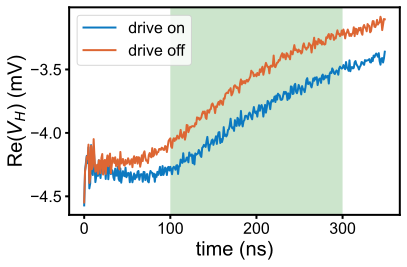

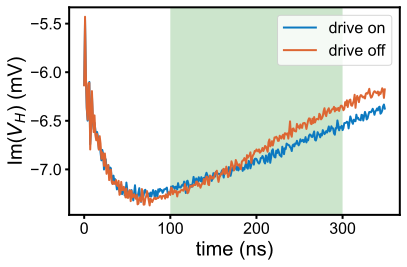

In [4]:
def plot_with_rectangle(data, ylabel):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data for drive on and off
    plt.plot(data[0], label='drive on')
    plt.plot(data[1], label='drive off')

    # Add a legend
    plt.legend()

    # Get the current y-axis limits
    ylim = ax.get_ylim()

    # Add a shaded rectangle to indicate a specific region
    ax.add_patch(patches.Rectangle((100, ylim[0]), 200, abs(ylim[0] - ylim[1]), facecolor='green', alpha=0.2))

    # Set the y-axis limits based on the data
    plt.ylim(ylim)

    # Set labels for the axes
    plt.ylabel(ylabel)
    plt.xlabel('time (ns)')

    # Apply tight layout to prevent clipping
    fig.tight_layout()

    return fig, ax

# Plot Re(V_H) with shaded region
fig, ax = plot_with_rectangle(I, 'Re($V_H$) (mV)')

# Plot Im(V_H) with shaded region
fig, ax = plot_with_rectangle(Q, 'Im($V_H$) (mV)')